In [46]:
import pywt
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import numpy as np

In [47]:
#connect to sql
db_path = "../Database/thesis_database.db"
conn = sqlite3.connect(db_path)

In [48]:
#get data from sql
enso_mei_long = pd.read_sql_query("SELECT * FROM enso_mei", conn)

In [49]:
# Compute the Fourier transform of the MEI values
#Format Date to datetime %Y%m
enso_mei_long['Date'] = pd.to_datetime(enso_mei_long['Date'])
# Remove rows with NaN values
enso_mei_long_cleaned = enso_mei_long.dropna(subset=['MEI'])

In [50]:
from numpy.fft import rfft, rfftfreq

# Perform the real-valued Fast Fourier Transform
fft_values = rfft(enso_mei_long_cleaned['MEI'])

# Obtain the corresponding frequencies
fft_freq = rfftfreq(len(enso_mei_long_cleaned['MEI']), d=1)

# Combine the frequency and FFT values into a DataFrame
fft_df = pd.DataFrame({'Frequency': fft_freq, 'Amplitude': np.abs(fft_values)})

# Find the top 5 frequencies excluding the zero frequency (mean of the series)
top_frequencies = fft_df[fft_df['Frequency'] > 0].nlargest(5, 'Amplitude')

top_frequencies


,Frequency,Amplitude
4,0.007449,153.864183
12,0.022346,133.572696
8,0.014898,116.754668
15,0.027933,99.788434
10,0.018622,99.419709


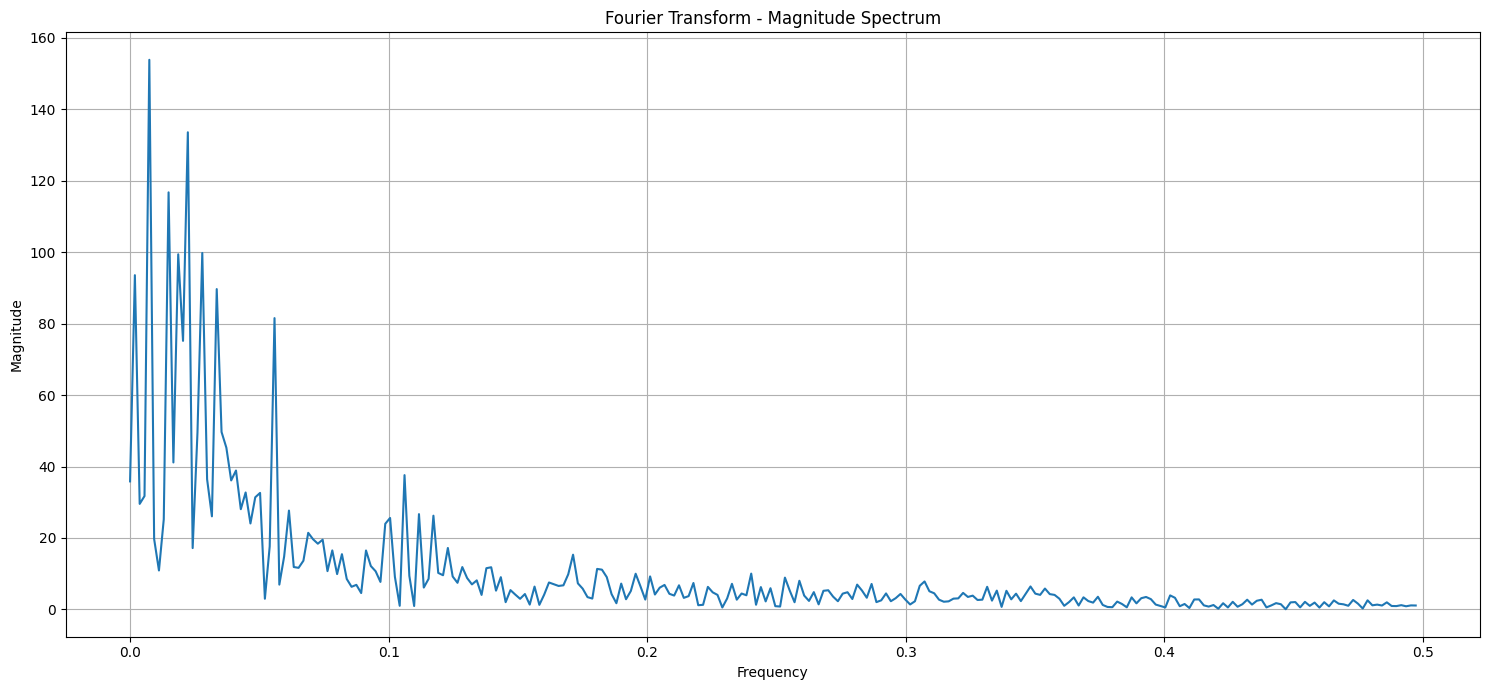

In [51]:


# Extract the time (in months) and MEI values from the cleaned data
time_cleaned = np.arange(len(enso_mei_long_cleaned))
mei_values_cleaned = enso_mei_long_cleaned['MEI'].values
fft_values = np.fft.fft(mei_values_cleaned)
frequencies = np.fft.fftfreq(len(mei_values_cleaned))

# Plot the magnitude spectrum
plt.figure(figsize=(15, 7))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_values)[:len(frequencies)//2])
plt.title('Fourier Transform - Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()

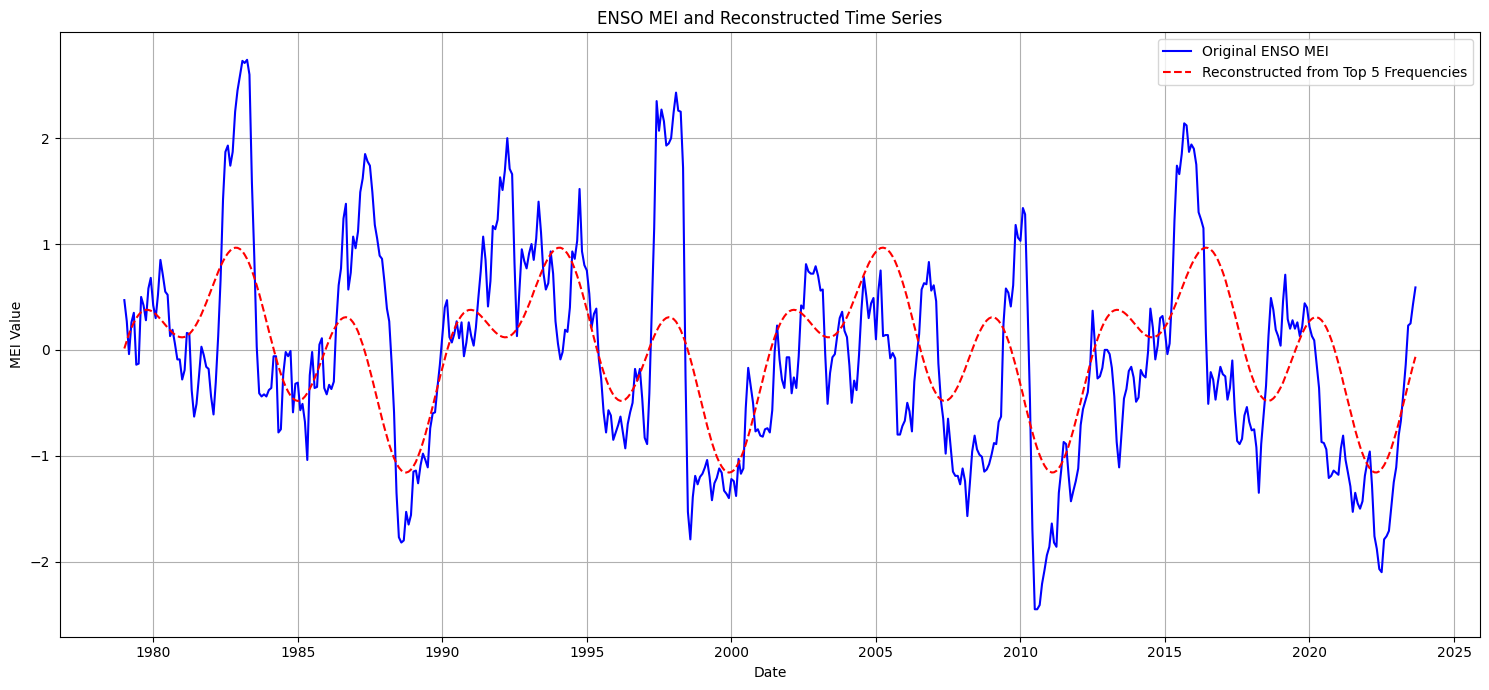

In [52]:
# Identify the top 5 dominant frequencies
top_n = 5
indices_sorted_by_magnitude = np.argsort(np.abs(fft_values))
top_indices = indices_sorted_by_magnitude[-top_n:]

# Zero out all frequencies except the top 5
filtered_fft_values = np.zeros_like(fft_values)
filtered_fft_values[top_indices] = fft_values[top_indices]

# Inverse Fourier transform to get the reconstructed time series
reconstructed_values = np.real(np.fft.ifft(filtered_fft_values))

# Plot the original and reconstructed time series
plt.figure(figsize=(15, 7))
plt.plot(enso_mei_long_cleaned['Date'], mei_values_cleaned, label='Original ENSO MEI', color='blue')
plt.plot(enso_mei_long_cleaned['Date'], reconstructed_values, label='Reconstructed from Top 5 Frequencies', color='red', linestyle='--')
plt.title('ENSO MEI and Reconstructed Time Series')
plt.xlabel('Date')
plt.ylabel('MEI Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


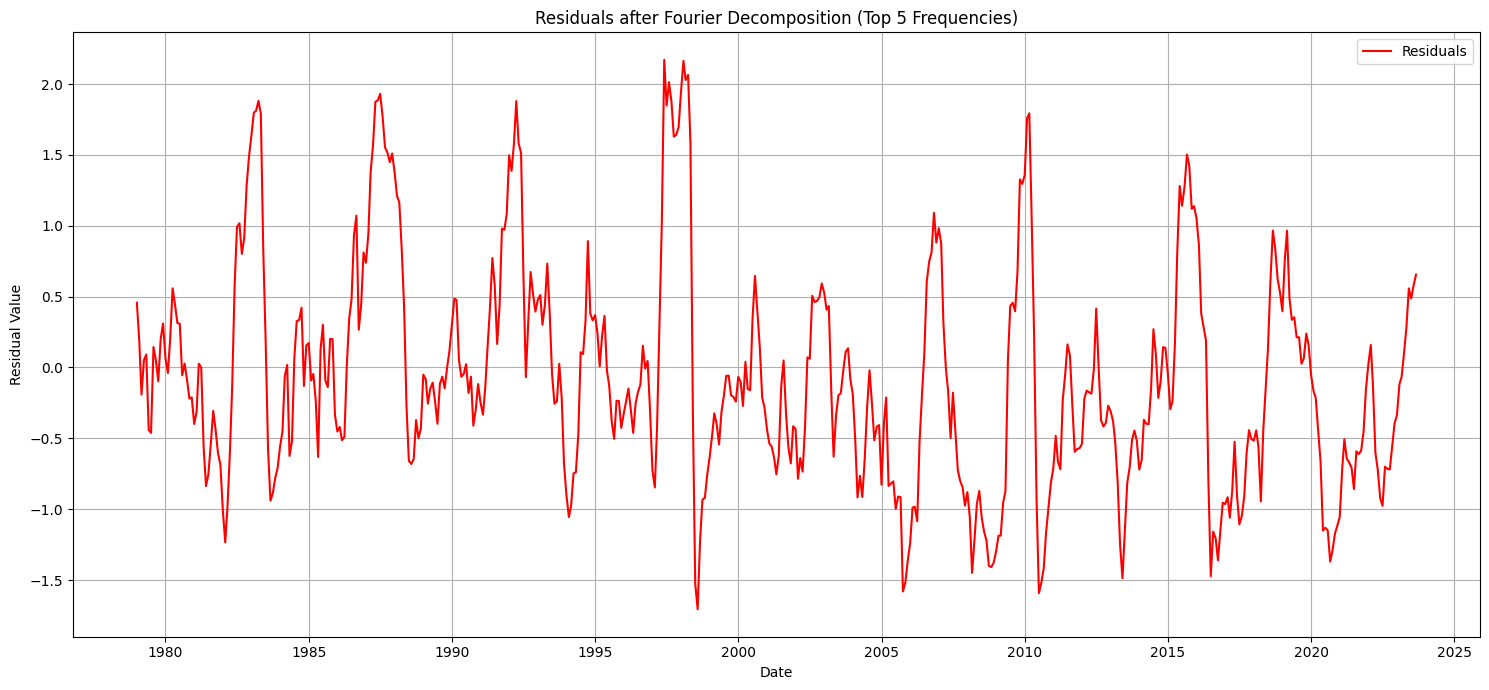

In [53]:
fourier_reconstructed_10 = np.fft.ifft(filtered_fft_values).real
residuals_5_freq = mei_values_cleaned - fourier_reconstructed_10

# Plot the residuals
plt.figure(figsize=(15, 7))
plt.plot(enso_mei_long_cleaned['Date'], residuals_5_freq, label='Residuals', color='red')
plt.title('Residuals after Fourier Decomposition (Top 5 Frequencies)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


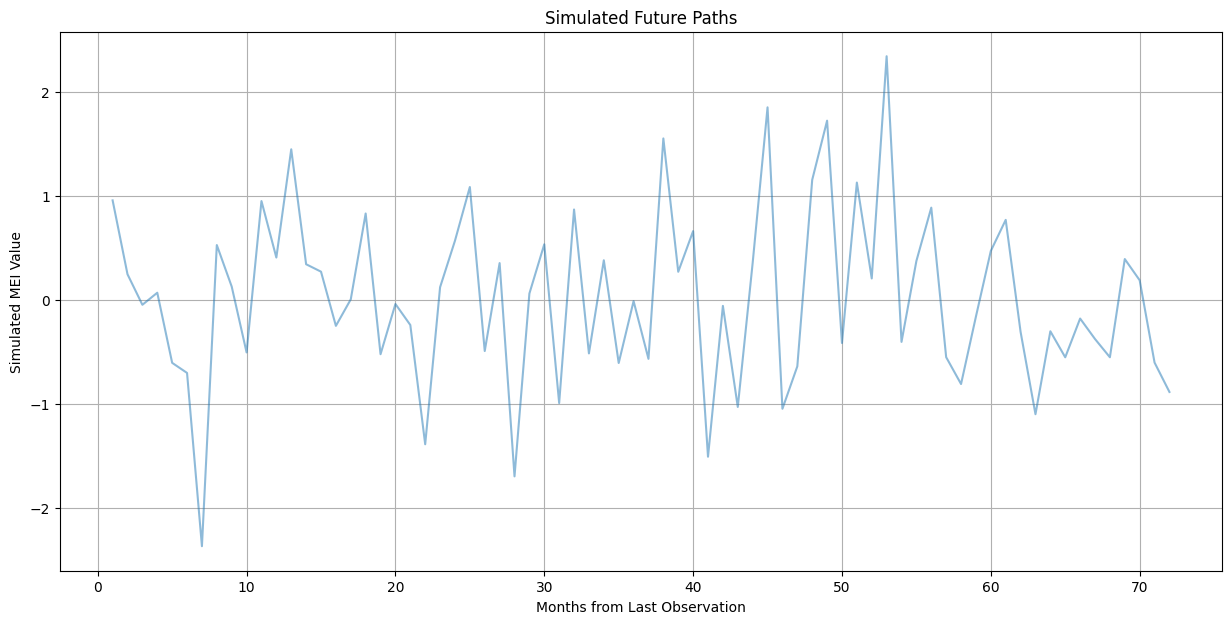

In [63]:
# Number of simulations
n_simulations = 1

# Simulate future residuals
forecasted_std = np.sqrt(forecasts.variance.dropna().values[-1])
simulated_residuals = np.random.normal(
    0,  # Assuming a mean of 0 for the residuals
    forecasted_std[:, np.newaxis],  # Add a new axis to make it a 2D array for broadcasting
    size=(72, n_simulations)
)

# Add the simulated residuals to the last known value of the reconstructed series
last_value = fourier_reconstructed_10[-1]  # Make sure this is a scalar value
simulated_paths = last_value + simulated_residuals

# Plotting the simulated paths
plt.figure(figsize=(15, 7))
for i in range(n_simulations):
    plt.plot(range(1, 73), simulated_paths[:, i], alpha=0.50)
plt.title('Simulated Future Paths')
plt.xlabel('Months from Last Observation')
plt.ylabel('Simulated MEI Value')
plt.grid(True)
plt.show()


In [55]:
from arch import arch_model
# Fit a GARCH(1, 1) model to the residuals
garch_model = arch_model(residuals_5_freq, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
# Display the GARCH model summary
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -430.405
Distribution:                  Normal   AIC:                           868.811
Method:            Maximum Likelihood   BIC:                           885.955
                                        No. Observations:                  537
Date:                Sun, Nov 05 2023   Df Residuals:                      536
Time:                        11:44:10   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2340  4.600e-02     -5.086  3.652e-07 [ -0.324, -0.144]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0460  8.132e-03      5.654  1.566e-08 [3.004e-02,6.192e-02]
alpha[1]       0.8654  5.725e-02     15.116  1.275e-51     [  0.753,  0.978]
beta[1]        0.0896  4.284e-02      2.093  3.638e-02   [5.683e-03,  0.174]
============================================================================

Covariance estimator: robust
"""

In [56]:
forecasts = garch_fit.forecast(start=0)
forecasted_values = forecasts.values.flatten()  # or any other range you're interested in
forecasted_values

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


AttributeError: 'ARCHModelForecast' object has no attribute 'values'

In [57]:
combined_series = np.concatenate((mei_values_cleaned, forecasted_values))
plt.figure(figsize=(15, 7))
plt.plot(combined_series, label='MEI + Forecasted')
plt.axvline(x=len(enso_mei_long_cleaned), color='red', linestyle='--', label='Start of Forecast')
plt.title('Original MEI values and Forecasted values')
plt.legend()
plt.show()

NameError: name 'forecasted_values' is not defined